# DS5559 Naive Bayes Wine Reviews v5 FINAL

## Synopsis

We attempt a Naive Bayes classifier for the sentiment of a corpus of wine reviews. We use the score of the review as our sentiment value, assuming that a bad review will have negative sentiment and a good review will have positive sentiment.

## Configuration

In [1]:
src_file = 'winereviews.csv'

# Set Hyperparameters
class Params():
    qntile_P = .9
    qntile_N = .1
    n_sets = 4
    smooth_alpha = .1
    binary_mode = True
params = Params()

## Libraries

In [2]:
import pandas as pd
import numpy as np
from numpy import log2 as log
from numpy import exp2 as exp
from numpy.random import randint
import textman as tx

## Pragmas

In [3]:
%matplotlib inline

# Process

## PREPARATION

### Import wine reviews

In [4]:
docs = pd.read_csv('winereviews.csv', index_col='doc_id')

In [5]:
docs.head()

,doc_content,points
doc_id,,
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


### Convert points to labels

#### Keep only reviews with high and low ratings

In [6]:
bound_P = int(docs['points'].quantile(params.qntile_P))
bound_N = int(docs['points'].quantile(params.qntile_N))
docs = docs[(docs.points <= bound_N) | (docs.points >= bound_P)]

In [7]:
docs.sample(5)

,doc_content,points
doc_id,,
61562,"The fruit is plenty ripe, offering rich flavor...",84
40930,"Concentrated and intense, but typical of Bonar...",83
109918,"This wine is supremely pretty, inviting in ros...",93
3114,"This wine is mostly Grenache, with about one-t...",84
110986,"A blend of Nero di Troia and Negroamaro, this ...",84


#### Assign labels for high and low

In [8]:
docs.loc[docs['points'] >= bound_P, 'doc_label'] = 'P'
docs.loc[docs['points'] <= bound_N, 'doc_label'] = 'N'

In [9]:
docs.head()

,doc_content,points,doc_label
doc_id,,,
336,"Gritty, heavily roasted aromas of peanuts and ...",83,N
337,"An easy and inviting selection, there's a ment...",83,N
338,The wine is earthy and somewhat rustic. There ...,82,N
339,"Red in color, with berry and apple aromas, thi...",82,N
340,"The nose is muted, despite the slight spritz o...",82,N


In [10]:
docs = docs.drop('points', 1)

In [11]:
docs.head()

,doc_content,doc_label
doc_id,,
336,"Gritty, heavily roasted aromas of peanuts and ...",N
337,"An easy and inviting selection, there's a ment...",N
338,The wine is earthy and somewhat rustic. There ...,N
339,"Red in color, with berry and apple aromas, thi...",N
340,"The nose is muted, despite the slight spritz o...",N


### Divide docs into train and test sets

#### Assign random numbers to docs

In [12]:
docs['set'] = randint(0,params.n_sets, len(docs.index))

In [13]:
docs.head()

,doc_content,doc_label,set
doc_id,,,
336,"Gritty, heavily roasted aromas of peanuts and ...",N,1
337,"An easy and inviting selection, there's a ment...",N,2
338,The wine is earthy and somewhat rustic. There ...,N,1
339,"Red in color, with berry and apple aromas, thi...",N,3
340,"The nose is muted, despite the slight spritz o...",N,0


#### Split docs by assigned number 

In [14]:
training_docs = docs[docs.set != 0].copy()
testing_docs = docs[docs.set == 0].copy()
del(docs)

In [15]:
training_docs = training_docs.drop('set', 1)
testing_docs = testing_docs.drop('set', 1)

In [16]:
round(len(training_docs) / len(testing_docs), 2)

3.03

### Convert docs to tokens

In [17]:
training_tokens, vocab = tx.create_tokens_and_vocab(training_docs, src_col='doc_content')
testing_tokens, _ = tx.create_tokens_and_vocab(testing_docs, src_col='doc_content')

In [18]:
training_tokens.head()

token term_str  term_id
doc_id sent_id token_id                           
336    0       0          Gritty   gritty     6439
               1         heavily  heavily     6694
               2         roasted  roasted    11692
               3          aromas   aromas      975
               5         peanuts  peanuts    10096

### Apply training vocab to testing -- CRUCIAL

In [19]:
testing_tokens['term_id'] = testing_tokens.term_str.map(vocab.reset_index().set_index('term_str').term_id)
testing_tokens = testing_tokens.dropna()
testing_tokens['term_id'] = testing_tokens['term_id'].astype('int')

In [20]:
testing_tokens.head()

token term_str  term_id
doc_id sent_id token_id                           
340    0       1            nose     nose     9446
               3           muted    muted     9208
               4         despite  despite     4061
               6          slight   slight    12723
               7          spritz   spritz    13109

#### Simplify tokens table 

In [21]:
training_tokens = training_tokens.reset_index()[['doc_id','term_id']]
testing_tokens = testing_tokens.reset_index()[['doc_id','term_id']]

In [22]:
if params.binary_mode:
    training_tokens = training_tokens.drop_duplicates()
    testing_tokens = testing_tokens.drop_duplicates()

In [23]:
training_tokens.head()

,doc_id,term_id
0,336,6439
1,336,6694
2,336,11692
3,336,975
4,336,10096


### Transfer doc labels and splits to tokens -- CRUCIAL

In [24]:
training_tokens = training_tokens.join(training_docs[['doc_label']], on='doc_id', how='inner')
# testing_tokens = testing_tokens.join(testing_docs[['doc_label']], on='doc_id', how='left')

In [25]:
training_tokens.head()

,doc_id,term_id,doc_label
0,336,6439,N
1,336,6694,N
2,336,11692,N
3,336,975,N
4,336,10096,N


## TRAINING

### Estimate class priors $p(c)$

$$
\hat{P}(c) = \dfrac{N_{c}}{N_{d}}
$$

In [26]:
Nc = training_docs['doc_label'].value_counts()
Nd = training_docs.shape[0]
class_priors = Nc / Nd

In [27]:
np.round(class_priors, 2)

P    0.5
N    0.5
Name: doc_label, dtype: float64

Since these are literally $50/50$, we really don't need them.

#### Convert priors to logs

In [28]:
class_priors_log = log(class_priors)

In [29]:
np.round(class_priors_log)

P   -1.0
N   -1.0
Name: doc_label, dtype: float64

### Estimate likelihoods $p(w|c)$

$$
\hat{P}(w_i|c) = \dfrac{count(w_i,c)}{\sum_{w \in V} count(w,c)}
$$

$$
\hat{P}(w_i|c) = \dfrac{count(w_i,c)+1}{\sum_{w \in V} (count(w,c)+1)} = \dfrac{count(w_i,c)+1}{(\sum_{w \in V} count(w,c))+|V|} 
$$



Now we compute the probability of a token given the label. This will in effect product two language models, one for each label. Key idea = **the likelihoods are language models** (see Pearl for interpretation of likelihoods).

In [30]:
class_likelihoods = training_tokens.groupby(['term_id', 'doc_label']).doc_label.count()\
    .unstack().fillna(0)

In [31]:
class_likelihoods = class_likelihoods + params.smooth_alpha
class_likelihoods = class_likelihoods / class_likelihoods.sum()

In [32]:
class_likelihoods.head()

doc_label,N,P
term_id,,
337,6.069302e-07,1.509003e-05
341,6.069302e-07,1.140953e-05
342,1.881484e-05,3.680495e-07
344,6.069302e-07,1.509003e-05
348,6.069302e-07,9.606091e-05


#### Convert likelihoods to logs

In [33]:
class_likelihoods_log = log(class_likelihoods)

In [34]:
class_likelihoods_log.head()

doc_label,N,P
term_id,,
337,-20.651966,-16.016045
341,-20.651966,-16.419401
342,-15.697770,-21.373597
344,-20.651966,-16.016045
348,-20.651966,-13.345691


## TESTING

### Add likelihood columns to test tokens table

This is effectively how we apply our model to the test set.

In [35]:
testing_tokens.head()

,doc_id,term_id
0,340,9446
1,340,9208
2,340,4061
3,340,12723
4,340,13109


In [36]:
testing_tokens = testing_tokens\
    .join(class_likelihoods_log[['P','N']], on='term_id', how='inner')

In [37]:
testing_tokens.sample(5)

,doc_id,term_id,P,N
29646,27062,9018,-15.223850,-20.651966
39121,35344,13872,-6.576898,-7.308919
91561,82618,6840,-12.005090,-12.864064
1527,1753,13919,-11.028192,-9.290571
95930,85795,7541,-13.239171,-12.800217


### Compute posteriors $p(c|w)$

$$
c_{NB} = \arg\max \log{P(c)} + \sum_{id=1}^{id_{max}} \log{P(token_{id}|c)}
$$




In [38]:
testing_docs['prediction'] = testing_tokens.groupby('doc_id')\
    .apply(lambda x: x[['P','N']].sum())\
    .apply(lambda x: x + class_priors_log, 1)\
    .idxmax(1)

In [39]:
testing_docs.head()

,doc_content,doc_label,prediction
doc_id,,,
340,"The nose is muted, despite the slight spritz o...",N,N
345,This wine contains some material over 100 year...,P,P
348,Deep mahogany. Dried fig and black tea on the ...,P,P
349,"RunRig is always complex, and the 2012 doesn't...",P,P
359,Up the slope above the Grand Cru of Le Montrac...,P,P


## EVALUATION

In [40]:
testing_docs['result'] = testing_docs.doc_label == testing_docs.prediction

In [41]:
testing_docs.head()

,doc_content,doc_label,prediction,result
doc_id,,,,
340,"The nose is muted, despite the slight spritz o...",N,N,True
345,This wine contains some material over 100 year...,P,P,True
348,Deep mahogany. Dried fig and black tea on the ...,P,P,True
349,"RunRig is always complex, and the 2012 doesn't...",P,P,True
359,Up the slope above the Grand Cru of Le Montrac...,P,P,True


### Show raw T & F count

In [42]:
raw = testing_docs.result.value_counts()

In [43]:
raw

True     5830
False     198
Name: result, dtype: int64

In [44]:
raw[True] / raw[False]

29.444444444444443

### Create confusion matrix

In [45]:
CM = testing_docs.reset_index().groupby(['prediction','doc_label']).doc_id.count().unstack().fillna(0)

In [46]:
CM.columns.name = 'actual'

In [47]:
CM

actual,N,P
prediction,,
N,2819,45
P,153,3011


In [48]:
def get_results(CM):

    class Results():
        
        TP = CM.iloc[0,0] # hits
        FP = CM.iloc[0,1] # Type I errors; false alarms
        TN = CM.iloc[1,1] # correct rejections
        FN = CM.iloc[1,0] # Type  II errors; misses
        T = TP + TN
        F = FP + FN
        ALL =  T + F
        ACC = T / ALL # Accuracy
        TPR = TP / (TP + FN) # Recall, Sensitivity
        TNR = TN / (TN + FP) # Specificity
        PPV = TP / (TP + FP)  # Precision; Positive predictive value 
        BA = (TNR + TPR) / 2 # Balanced Accuracy
        F1 = (2 *  TP) / (2 * TP + FP + FN) # F-score where F =  1

        assert ALL == CM.sum().sum()
                
        def show_results(self):
            print('TPR:', round(self.TPR, 2), '(sensitivity)')
            print('TNR:', round(self.TNR, 2), '(specificity)')
            print('F1: ', round(self.F1, 2), '<-- GRADE')
            print('-'*9)
            print('PPV:', round(self.PPV, 2),  '(precision)')
            print('ACC:', round(self.ACC, 2), '(accuracy)')
            
    return Results()

In [49]:
R = get_results(CM)

In [50]:
R.show_results()

TPR: 0.95 (sensitivity)
TNR: 0.99 (specificity)
F1:  0.97 <-- GRADE
---------
PPV: 0.98 (precision)
ACC: 0.97 (accuracy)


## EXPLORE

### Likelihoods as Sentiment Lexicon 

#### We make up a way to compute sentiment valence and polarity

In [51]:
sentilex = (np.sign(class_likelihoods['P'] - class_likelihoods['N'])).to_frame()\
    .rename(columns={0:'polarity'})
sentilex['valence'] = (class_likelihoods['P'] - class_likelihoods['N']) * 1000
sentilex['term_str'] = vocab.term_str
sentilex = sentilex.set_index('term_str')

#### Ratio of positive to negative terms

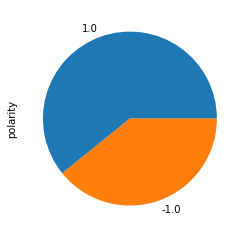

In [52]:
sentilex.polarity.value_counts().plot(kind='pie')

#### Top positive words

In [53]:
sentilex.sort_values('valence', ascending=False).head(10)

,polarity,valence
term_str,,
black,1.0,6.179032
rich,1.0,5.964492
years,1.0,4.869656
drink,1.0,4.807294
tannins,1.0,4.168445
ripe,1.0,3.969865
dark,1.0,3.653336
concentrated,1.0,3.627772
vineyard,1.0,3.503998


#### Top negative words

In [54]:
sentilex.sort_values('valence', ascending=True).head(10)

,polarity,valence
term_str,,
flavors,-1.0,-18.269401
aromas,-1.0,-8.955337
finish,-1.0,-8.692180
sweet,-1.0,-6.383192
simple,-1.0,-6.004778
soft,-1.0,-5.605911
green,-1.0,-4.930198
light,-1.0,-4.773671
like,-1.0,-4.078144


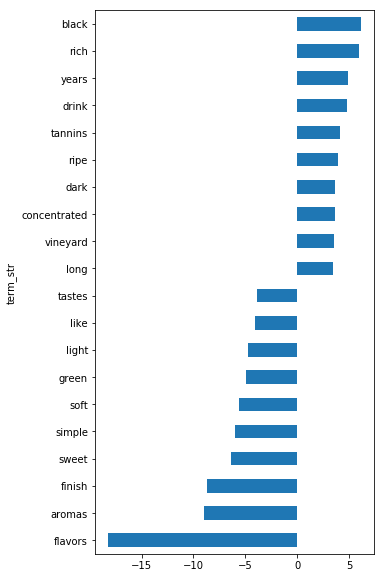

In [55]:
wpos = sentilex.valence.sort_values(ascending=False).head(10)
wneg = sentilex.valence.sort_values(ascending=False).tail(10)
pd.concat([wpos,wneg]).sort_values().plot.barh(figsize=(5,10))

### Expected Mutual Information

![](emi.png)

In [56]:
training_tokens.head()

,doc_id,term_id,doc_label
0,336,6439,N
1,336,6694,N
2,336,11692,N
3,336,975,N
4,336,10096,N


In [57]:
p_c = class_priors.to_frame()
p_c.columns = ['p']
p_c.index.name = 'doc_label'

In [58]:
p_c

,p
doc_label,
P,0.500384
N,0.499616


In [59]:
p_w = (training_tokens.term_id.value_counts() / training_tokens.shape[0]).to_frame()
p_w.columns = ['p']
p_w.index.name = 'term_id'
p_w['term_str'] = vocab.term_str

In [60]:
p_w.sort_values('p', ascending=False).head()

,p,term_str
term_id,,
15553,0.021432,wine
5554,0.019652,flavors
5892,0.013328,fruit
9924,0.011266,palate
975,0.010836,aromas


In [61]:
p_cw = training_tokens.groupby(['term_id','doc_label']).count() / training_tokens.shape[0]
p_cw.columns = ['p']

In [62]:
p_cw.head()

,,p
term_id,doc_label,
337,P,0.000009
341,P,0.000007
342,N,0.000007
344,P,0.000009
348,P,0.000060


In [63]:
EMI = training_tokens.join(p_cw, on=['term_id','doc_label'], how='left').rename(columns={'p':'p_cw'})
EMI = EMI.join(p_w['p'], on='term_id', how='left').rename(columns={'p':'p_w'})
EMI = EMI.join(p_c, on='doc_label', how='left').rename(columns={'p':'p_c'})
EMI = EMI.join(vocab['term_str'], on='term_id', how='left')
EMI['emi'] = EMI.p_cw * log(EMI.p_cw/(EMI.p_c * EMI.p_w))
EMI = EMI[['doc_label','term_id','term_str','emi']].drop_duplicates().set_index(['doc_label','term_id'])

In [64]:
VN = EMI.loc['N'].sort_values('emi', ascending=False).head(100)

In [65]:
VP = EMI.loc['P'].sort_values('emi', ascending=False).head(100)

In [66]:
VP.head()

,term_str,emi
term_id,,
1616,black,0.004333
4454,drink,0.003946
11601,rich,0.003881
13872,tannins,0.003598
11644,ripe,0.003130


In [67]:
VN.head()

,term_str,emi
term_id,,
5554,flavors,0.003003
12604,simple,0.002256
6394,green,0.001381
13729,sweet,0.001373
12841,soft,0.001338
